# Simulating catalogs

This tutorial shows how to generate mock catalogs of Galactic binaries

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from corner import corner
from fast_lisa_subtraction import GalacticBinaryPopulation, SourceCatalog, SubtractionAlgorithm

# Specify the device to use for computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Simulate a DWD Population

We first use the `GalacticBinaryPopulation` class to draw samples of a DWD Population.

This class uses the the parametrization explained in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX) and is by default initialized to reproduce the best fit to the catalog of [Lamberts A. et al. (2019)](https://academic.oup.com/mnras/article/490/4/5888/5585418)

In [ ]:
# Instantiate the GalacticBinaryPopulation class
GB_population = GalacticBinaryPopulation(device=device)

# Generate samples from the population
N = int(7e6)
GB_population_samples = GB_population.sample(N, copula=True, kind='gaussian', rho=0.995)

# Convert to a dataframe and inspect the columns
GB_population_df = GB_population_samples.dataframe()

We then can plot the distribution in $(f, \dot{f}, \mathcal{A})$

[WARNING] - Too few points to create valid contours


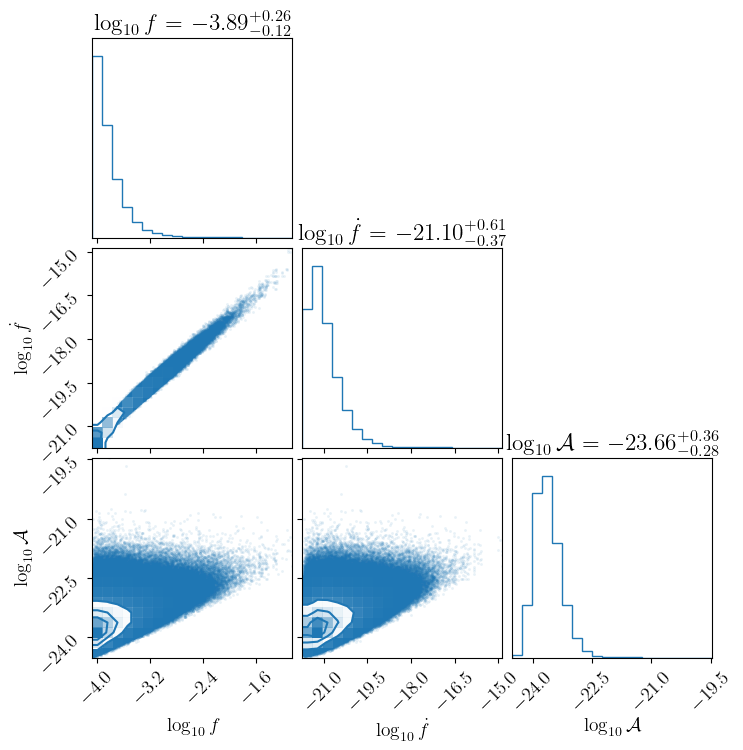

In [3]:
samples_numpy = GB_population_samples.numpy()
plot_samples = np.log10(samples_numpy[:, [0, 1, 2]]) 

fig = corner(plot_samples, labels=[r'$\log_{10}f$', r'$\log_{10}\dot{f}$', r'$\log_{10}\mathcal{A}$'], show_titles=True, color='C0')

### Sources generation

We now generate the sources from the catalog above and inject into a LISA datastream.
We use `SourceCatalog` to generate and save the catalog. 

We need to specify:

- `Nmax_binaries`: Number of sources to generate. If `None`, the full catalog is generated.

- `Nbatch`: Number of sources processed per batch. This is useful to control memory usage, especially when running on GPU.

- `Tobs`: Observation time (in years).  
  
- `AET`: If `True`, the output is provided in the AET TDI basis.vOtherwise, the output may be in the XYZ basis.

- `save`: If `True`, the generated catalog and/or time series are saved to disk.

- `oversample`: Oversampling factor used when generating the time series.

- `tdi2`: If `True`, second-generation TDI (TDI 2.0) is used.

- `outdir`: Output directory where generated files will be stored.


This return as an output a dictionary with all the metadata and the TDI channels

In [10]:
catalog = SourceCatalog(catalog_df=GB_population_df, use_gpu=True if device=='cuda' else False)

AET = catalog.generate_catalogue(
    Nmax_binaries = None, 
    Nbatch        = 10000,
    Tobs          = 4,
    AET           = True,
    save          = True,
    oversample    = 1,
    tdi2          = True, 
    outdir        = os.getcwd(),
)

catalog_path = os.path.join(os.getcwd(), f'GB_catalogue_{N}_binaries.h5')
tdi_data_path = os.path.join(os.getcwd(), f'tdi_cat_GB_catalogue_{N}_binaries.h5')

[INFO] - Cupy is available: using the GPU
Generating waveforms: 100%|██████████| 700/700 [00:06<00:00, 102.46it/s]
[INFO] - Saving the catalogue with 7000000 binaries
[INFO] - TDI catalogue saved in /home/fdesanti/work/LISA/fast-lisa-subtraction/examples/tdi_cat_GB_catalogue_7000000_binaries.h5
[INFO] - Catalogue saved in /home/fdesanti/work/LISA/fast-lisa-subtraction/examples/GB_catalogue_7000000_binaries.h5
